# Setup

## Install necessary libraries


In [1]:
%%capture
!pip install folktables munch fedlab fedartml

## Import libraries and dependencies

In [2]:
import os
import math
import torch
import torch.nn as nn
import numpy as np

# Plot
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from matplotlib.ticker import PercentFormatter

# Dataset definition
from folktables import ACSDataSource, ACSIncome
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle

# Configuration
from munch import Munch

# Federated dataset
from fedlab.contrib.dataset.basic_dataset import FedDataset
from fedartml import SplitAsFederatedData
from fedartml.function_base import hellinger_distance

# Client local training
from tqdm import tqdm
from sklearn.metrics import f1_score
from fedlab.contrib.algorithm.basic_client import SGDSerialClientTrainer

# Server global aggregation pipelines
from copy import deepcopy
from typing import List
from fedlab.contrib.algorithm.basic_server import SyncServerHandler
from fedlab.utils.aggregator import Aggregators
from fedlab.utils.serialization import SerializationTool

# FedLab pipeline
from fedlab.core.standalone import StandalonePipeline

## Define the available device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

## Define utility functions

In [4]:
# Define the AverageMeter class
class AverageMeter(object):
    """Record metrics information"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0.0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
# Function for the Average Odds computation
def average_odds(y, yhat, attr):

  # Convert to floating point tensors
  y, yhat = y.float(), yhat.float()

  # Compute TRP and FPR for the first group
  tpr_0 = torch.mean(yhat[(y == 1) & (attr == 0)])
  fpr_0 = torch.mean(yhat[(y == 0) & (attr == 0)])

  # Compute TPR and FPR for the second group
  tpr_1 = torch.mean(yhat[(y == 1) & (attr == 1)])
  fpr_1 = torch.mean(yhat[(y == 0) & (attr == 1)])

  # Compute Average Odds
  average_odds = 0.5 * (abs(tpr_0 - tpr_1) + abs(fpr_0 - fpr_1))

  return average_odds.item()

# Function for the Equal Opportunity computation
def equal_opportunity(y, yhat, attr):

    # Convert to floating point tensors
    y, yhat = y.float(), yhat.float()

    # Compute TPR for the first group
    tpr_0 = torch.mean(yhat[(y == 1) & (attr == 0)])

    # Compute TPR for the second group
    tpr_1 = torch.mean(yhat[(y == 1) & (attr == 1)])

    # Compute Equal Opportunity Difference
    eopp = abs(tpr_0 - tpr_1)

    return eopp.item()

# Function for the Demographic Parity computation
def demographic_parity(yhat, attr):

    # Convert to floating point tensor
    yhat = yhat.float()

    # Compute the true prediction probability for each group
    true_prob_0 = torch.mean(yhat[attr == 0])
    true_prob_1 = torch.mean(yhat[attr == 1])

    # Compute Demographic Parity Difference
    dp = abs(true_prob_0 - true_prob_1)

    return dp.item()

# Function to evaluate the final global model in different non-IIDness conditions
def evaluate_global_model(alpha_values, save_folder, device):

  loss_values = []
  acc_values = []
  f1_values = []
  ao_values = []
  eopp_values = []
  dp_values = []

  for alpha_value in alpha_values:
    save_path = save_folder + f"alpha_{alpha_value}.pth"
    model = get_model(ckpt=save_path)

    loss, acc, f1, ao, eopp, dp = evaluate(model, torch.nn.CrossEntropyLoss(), args.test_loader)
    loss_values.append(loss)
    acc_values.append(acc)
    f1_values.append(f1)
    ao_values.append(ao)
    eopp_values.append(eopp)
    dp_values.append(dp)

  return loss_values, acc_values, f1_values, ao_values, eopp_values, dp_values

In [6]:
# Sample num_seeds random seeds from the full int64 range
def sample_seeds(num_seeds):

  np.random.seed(42)

  seeds = set()
  while len(seeds) < num_seeds:
      seeds.update(np.random.randint(0, 2**32, size=num_seeds - len(seeds)))

  seeds = np.array(list(seeds))

  return seeds

# Returns a dictionary with alpha values as dictionary keys and HDs as dictionary values
def get_alpha_dict(alpha_values):

  alpha_dict = {}

  for alpha_value in alpha_values:

    # Get the federated dataset for the current alpha value
    fed_acs = PartitionedDataset(root=args.root,
                        path=args.path,
                        num_clients=args.num_clients,
                        partition=args.partition,
                        alpha=alpha_value,
                        device=device,
                        seed=args.part_seed,
                        preprocess=args.preprocess,
                        download=True,
                        verbose=True,
                        transform=None)

    # Get Hellinger distance
    hd = fed_acs.get_hd()

    # Associate the rounded HD to the alpha value in the dictionary
    alpha_dict[alpha_value] = round(hd, 2)

  return alpha_dict


# Returns an array containing an array of four category counts for each client
def get_client_counts():

  client_counts = []

  for cid in range(args.num_clients):
      client_dataset = args.fed_dataset.get_dataset(cid)
      groups, labels = client_dataset.data[:, 0], client_dataset.targets

      # Category order (group, label): (0,0), (0,1), (1,0), (1,1)
      client_count = np.zeros(4)
      for x, y in zip(groups, labels):
          index = int(x) * 2 + int(y)
          client_count[index] += 1
      client_counts.append(client_count)

  client_counts = np.array(client_counts)

  return client_counts

# Function extracting counts according to protected attribute and label
def extract_counts(client_counts):
  female_counts = []
  male_counts = []
  low_income_counts = []
  high_income_counts = []

  for client_count in client_counts:
      female_counts.append(client_count[0] + client_count[1])
      male_counts.append(client_count[2] + client_count[3])
      low_income_counts.append(client_count[0] + client_count[2])
      high_income_counts.append(client_count[1] + client_count[3])

  return female_counts, male_counts, low_income_counts, high_income_counts

# Function to get HD between labels in the protected attribute skew case
def get_label_hd(args):

  pctg_distr = []

  for cid in range(args.num_clients):

    # Get the dataset of each client
    dataset =  args.fed_dataset.get_dataset(cid)

    # Count the number of data points per label
    data_size = len(dataset.targets)
    count_0 = np.sum(np.array(dataset.targets.cpu()) == 0)
    count_1 = np.sum(np.array(dataset.targets.cpu()) == 1)

    # Calculate the distribution
    client_distr = [count_0 / data_size, count_1 / data_size]
    pctg_distr.append(client_distr)

  hd = hellinger_distance(pctg_distr)

  return hd

# Function to get HD between protected attributes in the label skew case
def get_attr_hd(args):

  pctg_distr = []

  for cid in range(args.num_clients):

    # Get the dataset of each client
    dataset =  args.fed_dataset.get_dataset(cid)

    # Count the number of data points per label
    data_size = len(dataset.data)
    count_0 = np.sum(np.array(dataset.data[:, 0].cpu()) == 0)
    count_1 = np.sum(np.array(dataset.data[:, 0].cpu()) == 1)

    # Calculate the distribution
    client_distr = [count_0 / data_size, count_1 / data_size]
    pctg_distr.append(client_distr)

  hd = hellinger_distance(pctg_distr)

  return hd

In [7]:
# Function to print federated execution configuration
def print_config(args):

  execution_config = f"""
  Algorithm: {args.algorithm}

  [SIMULATION CONFIGURATION]
  Number of clients: {args.num_clients}
  Partition: {args.partition}
  Alpha: {args.alpha}
  Partition seed: {args.part_seed}
  Preprocess: {args.preprocess}
  Cuda: {args.cuda}

  [CLIENT CONFIGURATION]
  Epochs: {args.epochs}
  Batch size: {args.batch_size}
  Learning rate: {args.lr}

  [SERVER CONFIGURATION]
  Communication rounds: {args.com_round}
  Sample ratio: {args.sample_ratio}
  """

  print(execution_config)


# Function for federated data distribution plot
def plot_data_distribution(args):

  # Get federated dataset distribution
  data_distribution = args.fed_dataset.get_data_distribution()

  # Calculate positions for the bar plot
  positions = np.arange(len(data_distribution))

  # Create the plot with a specific figure size
  plt.figure(figsize=(10, 6))

  # Plot the bars with the colormap
  bars = plt.bar(positions, data_distribution, width=1.0, align='center', edgecolor='k', color='#1f77b4')

  # Customize the plot
  plt.title(f'Distribution of data among {args.num_clients} federated clients ({args.partition}~Dir(alpha = {args.alpha}))')
  plt.xlabel('Client ID')
  plt.ylabel('Data Fraction')

  # Display the plot
  plt.tight_layout()
  plt.show()


# Function plotting the data distribution of clients
def plot_distributed_data(args, client_counts):

    # Create subplots
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=False)
    titles = [
        f'Client Data Distributions ({args.partition}~Dir(alpha = {args.alpha}))',
        f'Client Label Distributions ({args.partition}~Dir(alpha = {args.alpha}))',
        f'Client Protected Attribute Distributions ({args.partition}~Dir(alpha = {args.alpha}))'
    ]

    # Set up bar positions
    bar_width = 0.7
    bar_positions = np.arange(args.num_clients)

    for idx, ax in enumerate(axes):
        if idx == 0:
            categories = ['Female Salary < 50K$', 'Female Salary ≥ 50K$', 'Male Salary < 50K$', 'Male Salary ≥ 50K$']
            colors = ['#d62728', '#2ca02c', '#ff7f0e', '#1f77b4']
            count_category = [client_counts[:, i] for i in range(len(categories))]

        elif idx == 1:
            categories = ['Salary < 50K$', 'Salary ≥ 50K$']
            colors = ['#d62728', '#1f77b4']
            count_category_0 = client_counts[:, 0] + client_counts[:, 2]
            count_category_1 = client_counts[:, 1] + client_counts[:, 3]
            count_category = [count_category_0, count_category_1]

        else:
            categories = ['Female', 'Male']
            colors = ['#d62728', '#1f77b4']
            count_category_0 = client_counts[:, 0] + client_counts[:, 1]
            count_category_1 = client_counts[:, 2] + client_counts[:, 3]
            count_category = [count_category_0, count_category_1]

        # Plot each category
        bottoms = np.zeros(args.num_clients)
        for i, category in enumerate(categories):
            ax.bar(bar_positions, count_category[i], bar_width, label=category, color=colors[i], bottom=bottoms, edgecolor='black')
            bottoms += count_category[i]

        # Set labels and title
        ax.set_ylabel('Number Of Data Points', fontsize=12)
        ax.set_title(titles[idx], fontsize=14)

        # Set x-ticks
        tick_positions = np.arange(args.num_clients*args.sample_ratio, args.num_clients, args.num_clients*args.sample_ratio)
        ax.set_xticks(tick_positions)
        ax.set_xlabel('Clients', fontsize=12)

        # Add legend
        ax.legend(loc='upper right', fontsize=10)

    # Adjust layout for better spacing
    plt.tight_layout(pad=3.0)
    plt.show()

# Function displaying a scatter plot of client datasets
def scatter_plot_grid(args, client_counts):

    # Extract protected group/label counts: female, male, low_income, high_income
    counts = extract_counts(client_counts)
    labels = ["Female", "Male", "Low Income", "High Income"]

    # Define an index mapping dictionary
    index_mapping = {
        0: (0, 1),
        1: (0, 2),
        2: (0, 3),
        3: (1, 2),
        4: (1, 3),
        5: (2, 3)
    }

    # Define the grid with subplots and the title
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    fig.suptitle(f"Scatter Plots ({args.partition}~Dir(alpha = {args.alpha}))", fontsize=16)

    # Flatten the axes array
    axes = axes.flatten()

    # Loop through each subplot
    for i, ax in enumerate(axes):
        x_idx, y_idx = index_mapping[i]
        x_data, y_data = counts[x_idx], counts[y_idx]
        x_label, y_label = labels[x_idx], labels[y_idx]

        # Scatter plot on each subplot
        ax.scatter(x_data, y_data, color="blue", marker="o")

        # Set title and labels
        ax.set_xlabel(f"Number Of {x_label} Samples", fontsize=12)
        ax.set_ylabel(f"Number Of {y_label} Samples", fontsize=12)

        # Show grid
        ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Function to plot the relationship between non-IIDness and metrics
def plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics):

  hd_values = [alpha_dict[alpha_value] for alpha_value in alpha_dict.keys()]
  ylabels = ['Loss', 'Accuracy', 'F1 Score', 'Average Odds', 'Equal Opportunity', 'Demographic Parity']
  colors = ['r', 'b', 'y', 'g', 'm', 'c']

  fig, axs = plt.subplots(2, 3, figsize=(20, 10))

  for idx, ax in enumerate(axs.flat):
    ax.set_xlabel("Hellinger Distance")
    ax.set_ylabel(ylabels[idx])
    ax.plot(hd_values, metrics[idx], color = colors[idx])

    ax.axhline(y=baseline_metrics[idx], color='k', linestyle='--')

    if ylabels[idx] != 'Loss':
      ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
    ax.grid(True)

  plt.tight_layout()
  plt.show()

# Data Preparation

In [8]:
def get_data(survey_year="2018", horizon="1-Year", states=["CA"]):

  # Get data downloaded from data source
  data_source = ACSDataSource(survey_year=survey_year, horizon=horizon, survey='person')
  acs_data = data_source.get_data(states=states, download=True)
  X, y, _ = ACSIncome.df_to_numpy(acs_data)

  # Reorder the features to move the protected attribute at the front
  X = X[:, [8, *range(8), 9]]

  # Modify the protected attribute values according to tha advantaged/disadvantaged notation
  X[X[:, 0] == 2, 0] = 0

  # Train-Test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Define a data scaler
  datascaler = MinMaxScaler()
  datascaler.fit(X_train)
  X_train, X_test = datascaler.transform(X_train), datascaler.transform(X_test)

  return X_train, y_train, X_test, y_test

In [9]:
def get_extra_samples(X_train, y_train):

  # Initialize a dictionary to track whether each sample group has been added
  samples_needed = {(0, 0): False, (0, 1): False, (1, 0): False, (1, 1): False}
  X_extra, y_extra = [], []

  i = 0
  while not all(samples_needed.values()):
      X, y = X_train[i], y_train[i]
      pair = (X[0], y)

      # Add the sample if it hasn't been added yet
      if not samples_needed[pair]:
        X_extra.append(X)
        y_extra.append(y)
        samples_needed[pair] = True

      i += 1

  X_extra, y_extra = np.array(X_extra), np.array(y_extra)

  return X_extra, y_extra

In [10]:
class ClientDataset(Dataset):
    def __init__(self, data, targets, device):
        self.device = device

        self.data = torch.tensor(data, dtype=torch.float32, device=self.device)
        self.targets = torch.tensor(targets, dtype=torch.long, device=self.device)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
         return self.data[idx], self.targets[idx]

# Model Definition


The defined architecture is a feed-forward network with a single hidden layer of 64 neurons and ReLU activation. The model is trained with cross-entropy (CE) loss for 𝑇 = 300 epochs at batch size 128 and learning rate 1𝑒−3.

In [11]:
class MLP(nn.Module):
  def __init__(self):
      super(MLP, self).__init__()

      self.fc1 = nn.Linear(in_features=10, out_features=64)
      self.fc2 = nn.Linear(in_features=64, out_features=2)

      self.relu = nn.ReLU()

  def forward(self, x):

     x = self.relu(self.fc1(x))
     x = self.fc2(x)

     return x

def get_model(init_seed=42, ckpt=None):

  # Set weight initialization seed
  torch.manual_seed(init_seed)

  if ckpt is not None:
    # Load model from checkpoint
    model = torch.load(ckpt, map_location=device, weights_only=False)
  else:
    model = MLP()

  return model

# Centralized Baseline

In [12]:
class CentralizedTrainer():
  """Centralized training handler.

    Args:
        model (torch.nn.Module): PyTorch model.
        cuda (bool, optional): use GPUs or not. Default: ``False``.
        device (str, optional): Assign model/data to the given GPUs. E.g., 'device:0' or 'device:0,1'. Defaults to None.
    """
  def __init__(self,
               model:torch.nn.Module,
               cuda:bool=False,
               device:str=None):

    self.model = model
    self.device = device
    if self.device is not None:
      self.cuda = self.device.type == 'cuda'


  def train(self,
            train_loader,
            rr=True,
            epochs=300,
            lr=0.001):

    self.train_loader = train_loader
    self.rr = rr
    self.epochs = epochs
    self.lr = lr

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr = self.lr)

    self.model.train()

    for epoch in tqdm(range(self.epochs)):

      # Seed fixing the shuffling at each epoch if RR is used
      if (self.rr):
        torch.manual_seed(epoch)

      for batch_idx, (data, target) in enumerate(train_loader):
        if self.cuda:
          data = data.cuda(self.device)
          target = target.cuda(self.device)

        # Zero the gradients for every batch
        self.optimizer.zero_grad()

        # Compute the outputs of the model
        output = self.model(data)

        # Compute the loss
        loss = self.criterion(output, target)

        # Compute loss gradient
        loss.backward()

        # Adjust learning weights
        self.optimizer.step()

    return self.model

  def evaluate(self,
            data_loader):

    self.criterion = nn.CrossEntropyLoss()

    self.model.eval()
    gpu = next(self.model.parameters()).device

    loss_ = AverageMeter()
    acc_ = AverageMeter()

    labels_array = []
    predicted_array = []
    attr_array = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            batch_size = len(labels)
            inputs = inputs.to(gpu)
            labels = labels.to(gpu)

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)

            loss_.update(loss.item(), batch_size)
            acc_.update(torch.sum(predicted.eq(labels)).item() / batch_size, batch_size)

            attr = torch.tensor([features[0].item() for features in inputs.cpu()])

            labels_array.extend(labels.cpu())
            predicted_array.extend(predicted.cpu())
            attr_array.extend(attr.cpu())

        labels_array = torch.tensor(labels_array)
        predicted_array = torch.tensor(predicted_array)
        attr_array = torch.tensor(attr_array)

        f1 = f1_score(labels_array, predicted_array, average='macro')
        ao = average_odds(labels_array, predicted_array, attr_array)
        eopp = equal_opportunity(labels_array, predicted_array, attr_array)
        dp = demographic_parity(predicted_array, attr_array)

    return loss_.avg, acc_.avg, f1, ao, eopp, dp

In [13]:
# Function defining the training of a specific model instance
def centralized_train(data, device, init_seed=42, rr_seed=42, num_epochs=300):

  # Get the centralized model
  c_model = get_model(init_seed=init_seed).to(device)

  # Define the centralized trainer
  c_trainer = CentralizedTrainer(c_model, device=device)

  # Get training features and labels
  X_train, y_train = data[:2]
  trainset = ClientDataset(X_train, y_train, device)
  if (rr_seed is not None):
    trainset.data, trainset.targets = shuffle(trainset.data, trainset.targets, random_state=rr_seed)
  train_loader = DataLoader(trainset, batch_size=128, shuffle=True)

  # Train on whole train dataset
  c_model = c_trainer.train(train_loader, epochs=num_epochs)

  return c_trainer

# Function defining different runs of model training
def centralized_baseline(data, device, models_path, num_runs=50):

  # Sample num_runs random initialization seeds from the full int64 range
  seeds = sample_seeds(num_runs)

  for run_idx in range(num_runs):

    # Allow initialization and Random Reshuffling variablity
    c_trainer = centralized_train(data, device, init_seed=seeds[run_idx], rr_seed=seeds[run_idx])

    # Save the final model
    torch.save(c_trainer.model, os.path.join(models_path, f'model_{run_idx}'))


# Function evaluating the performance of the models obtained from the runs
def baseline_evaluation(test_loader, models_path, values_path, num_runs=50):

  # Record metrics across runs
  loss_values, acc_values, f1_values, ao_values, eopp_values, dp_values = [], [], [], [], [], []

  for run_idx in range(num_runs):

    # Load the model and define the trainer
    c_model = get_model(ckpt= os.path.join(models_path, f"model_{run_idx}"))
    cuda = device.type == 'cuda'
    c_trainer = CentralizedTrainer(c_model, cuda=cuda, device=device)

    # Evaluate the trained model
    loss, acc, f1, ao, eopp, dp = c_trainer.evaluate(test_loader)

    # Record the obtained values
    loss_values.append(loss)
    acc_values.append(acc)
    f1_values.append(f1)
    ao_values.append(ao)
    eopp_values.append(eopp)
    dp_values.append(dp)

  # Save arrays to .npy files
  np.save(os.path.join(values_path, 'loss_values.npy'), np.array(loss_values))
  np.save(os.path.join(values_path, 'acc_values.npy'), np.array(acc_values))
  np.save(os.path.join(values_path, 'f1_values.npy'), np.array(f1_values))
  np.save(os.path.join(values_path, 'ao_values.npy'), np.array(ao_values))
  np.save(os.path.join(values_path, 'eopp_values.npy'), np.array(eopp_values))
  np.save(os.path.join(values_path, 'dp_values.npy'), np.array(dp_values))


# Function to obtain the metrics values of centralized baseline
def get_baseline_metrics(baseline_path, mean=True):

  if os.path.exists(baseline_path):
    loss_baseline = np.load(os.path.join(baseline_path, 'loss_values.npy'))
    acc_baseline = np.load(os.path.join(baseline_path, 'acc_values.npy'))
    f1_baseline = np.load(os.path.join(baseline_path, 'f1_values.npy'))
    ao_baseline = np.load(os.path.join(baseline_path, 'ao_values.npy'))
    eopp_baseline = np.load(os.path.join(baseline_path, 'eopp_values.npy'))
    dp_baseline = np.load(os.path.join(baseline_path, 'dp_values.npy'))

    if (mean):
      loss_baseline = np.mean(loss_baseline)
      acc_baseline = np.mean(acc_baseline)
      f1_baseline = np.mean(f1_baseline)
      ao_baseline = np.mean(ao_baseline)
      eopp_baseline = np.mean(eopp_baseline)
      dp_baseline = np.mean(dp_baseline)

    return loss_baseline, acc_baseline, f1_baseline, ao_baseline, eopp_baseline, dp_baseline

  else:
    print("Invalid baseline path.")
    return

# Function to plot the metrics range over different runs
def plot_centralized_baseline(baseline_metrics):
    metrics = ['Loss', 'Accuracy', 'F1 Score', 'Average Odds', 'Equal Opportunity', 'Demographic Parity']

    # Use default style
    plt.style.use('default')

    # Create subplots and add a title
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle('Centralized Baseline', fontsize=24, fontweight='bold', y=1.01) #, y=1.02)

    # Iterate over the axes and metrics to create the boxplots
    for idx, ax in enumerate(axs.flat):
        ax.set_title(metrics[idx], fontsize=18, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Boxplot customization
        ax.boxplot(baseline_metrics[idx], showfliers=False, patch_artist=True,
                   boxprops=dict(facecolor='skyblue', color='navy'),
                   medianprops=dict(color='darkorange', linewidth=2))

        # Add grid lines with light color and dashed style
        ax.grid(True, axis='y', linestyle='--', color='grey', alpha=0.6)

        # Remove x-axis ticks
        ax.set_xticks([])

        # Customize y-ticks and labels
        yticks = ax.get_yticks()
        ax.yaxis.set_major_locator(ticker.FixedLocator(yticks))

        if metrics[idx] == 'Loss':
            ax.set_yticklabels([f'{y:.3f}' for y in yticks], fontsize=14)
        else:
            ax.set_yticklabels([f'{y*100:.1f}%' for y in yticks], fontsize=14)

    # Display the plot
    plt.tight_layout()
    plt.show()

In [14]:
# Set dataset ID
DATASET_ID = "acsincome"

# Get the dataset
data = get_data()

# Get test data
X_test, y_test = data[-2:]
testset = ClientDataset(X_test, y_test, device)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

In [15]:
# Define the metrics save path
models_path = f"models/{DATASET_ID}/centralized/"
os.makedirs(models_path, exist_ok=True)
values_path = f'values/{DATASET_ID}/centralized/'
os.makedirs(values_path, exist_ok=True)

In [16]:
# centralized_baseline(data, device, models_path)

In [17]:
# baseline_evaluation(test_loader, models_path, values_path)

In [18]:
# baseline_metrics = get_baseline_metrics(values_path, mean=False)
# plot_centralized_baseline(baseline_metrics)

# Federated Learning Setup


## Define federated dataset

In [19]:
class PartitionedDataset(FedDataset):
    """:class:`FedDataset` with partitioning preprocess. For detailed partitioning, please
    check `Federated Dataset and DataPartitioner <https://fedlab.readthedocs.io/en/master/tutorials/dataset_partition.html>`_.


    Args:
        root (str): Path to download raw dataset.
        path (str): Path to save partitioned subdataset.
        num_clients (int): Number of clients.
        seed (int): Random seed.
        partition (str): Partition scheme name.
        alpha (float): Dirichlet distribution parameter.
        device (torch.device): The available device.
        download (bool): Whether to download the raw dataset.
        preprocess (bool): Whether to preprocess the dataset.
        verbose (bool, optional): Whether to print partition process. Default as ``True``.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    """
    def __init__(self,
                 root,
                 path,
                 num_clients,
                 seed,
                 partition,
                 alpha,
                 device,
                 download=True,
                 preprocess=False,
                 verbose=True,
                 transform=None,
                 target_transform=None) -> None:

        self.root = os.path.expanduser(root)
        self.path = path
        self.num_clients = num_clients
        self.seed = seed
        self.partition = partition
        self.alpha = alpha
        self.device = device
        self.transform = transform
        self.target_transform = target_transform

        self.data_distribution = None
        self.hd = None

        if preprocess:
            self.preprocess(partition=partition,
                            alpha=alpha,
                            device=device,
                            verbose=verbose,
                            seed=seed,
                            download=download,
                            transform=transform,
                            target_transform=target_transform)

    def preprocess(self,
                   partition,
                   alpha,
                   device,
                   verbose=True,
                   seed=None,
                   download=True,
                   transform=None,
                   target_transform=None):
        """Perform FL partition on the dataset, and save each subset for each client into ``data{cid}.pkl`` file.

        For details of partition schemes, please check `Federated Dataset and DataPartitioner <https://fedlab.readthedocs.io/en/master/tutorials/dataset_partition.html>`_.
        """
        self.download = download

        if os.path.exists(self.path) is not True:
            os.makedirs(self.path, exist_ok=True)
            os.mkdir(os.path.join(self.path, "train"))
            os.mkdir(os.path.join(self.path, "var"))
            os.mkdir(os.path.join(self.path, "test"))

        # Instantiate a SplitAsFederatedData object
        my_federater = SplitAsFederatedData(random_state = self.seed)

        # Get training global features and labels
        data = get_data()
        X_train_glob, y_train_glob = data[:2]
        X_extra, y_extra = get_extra_samples(X_train_glob, y_train_glob)

        if (self.partition == "attr"):

            # Get the array relative to the protected attribute
            attr_array = X_train_glob[:, 0]

            # Get feature federated dataset skewed on sex feature from centralized dataset
            clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances, clients_glob_spatemp_dic = my_federater.create_clients(
                image_list = X_train_glob,
                label_list = y_train_glob,
                num_clients = self.num_clients,
                prefix_cli='Local_node',
                method = "no-label-skew",
                spa_temp_skew_method = "st-dirichlet",
                alpha_spa_temp = self.alpha,
                spa_temp_var = attr_array
            )

        # Default method: dirichlet
        else:
            # Get label skewed federated dataset from centralized dataset
            clients_glob_dic, list_ids_sampled_dic, miss_class_per_node, distances = my_federater.create_clients(
                image_list = X_train_glob,
                label_list = y_train_glob,
                num_clients = self.num_clients,
                prefix_cli='Local_node',
                method = "dirichlet",
                alpha = self.alpha
            )
            self.hd = distances['without_class_completion']['hellinger']

        clients_train = clients_glob_dic['without_class_completion']
        client_data_sizes = []

        for cid, client_name in enumerate(clients_train.keys()):
          client_train = clients_train[client_name]
          client_data_sizes.append(len(client_train))

          client_features = np.array([item[0] for item in client_train])
          client_features = np.concatenate((client_features, X_extra))

          client_labels = np.array([item[1] for item in client_train])
          client_labels = np.concatenate((client_labels, y_extra))

          client_dataset = ClientDataset(client_features, client_labels, self.device)

          torch.save(
              client_dataset,
              os.path.join(self.path, "train", "data{}.pkl".format(cid))
          )

        self.data_distribution = client_data_sizes / np.sum(client_data_sizes)

        if (self.partition == "attr"):

          pctg_distr = []

          for cid in range(self.num_clients):

            # Get the dataset of each client
            dataset =  self.get_dataset(cid)

            # Count the number of data points per group
            data_size = len(dataset.data)
            count_0 = np.sum(np.array(dataset.data[:, 0].cpu()) == 0)
            count_1 = np.sum(np.array(dataset.data[:, 0].cpu()) == 1)

            # Calculate the distribution
            client_distr = [count_0 / data_size, count_1 / data_size]
            pctg_distr.append(client_distr)

          self.hd = hellinger_distance(pctg_distr)


    def get_dataset(self, cid, type="train"):
        """Load subdataset for client with client ID ``cid`` from local file.

        Args:
             cid (int): client id
             type (str, optional): Dataset type, can be ``"train"``, ``"val"`` or ``"test"``. Default as ``"train"``.

        Returns:
            Dataset
        """
        dataset = torch.load(
            os.path.join(self.path, type, "data{}.pkl".format(cid)), weights_only=False)
        return dataset

    def get_dataloader(self, cid, batch_size=None, type="train", fair_order=False):
        """Return dataload for client with client ID ``cid``.

        Args:
            cid (int): client id
            batch_size (int, optional): batch size in DataLoader.
            type (str, optional): Dataset type, can be ``"train"``, ``"val"`` or ``"test"``. Default as ``"train"``.
            rr_seed (int, optional): Random Reshuffling seed, if employed. Default as ``"None"``.
        """
        dataset = self.get_dataset(cid, type)
        is_train = (type == "train")

        if (fair_order):
          dataset = set_fair_order(dataset)
          data_loader = DataLoader(dataset, batch_size, shuffle=False)
        else:
          data_loader = DataLoader(dataset, batch_size, shuffle=is_train)

        return data_loader

    def get_data_distribution(self):
      """Return distribution of federated dataset."""

      return self.data_distribution

    def get_hd(self):
      """Return Hellinger distance of federated dataset."""

      return self.hd

## Define utility functions

In [20]:
def set_fair_order(client_dataset):
  # Extract the indices of protected group and unprotected group instances
  attr = np.array(client_dataset.data[:, 0].cpu())
  indices_1 = np.where(attr == 0)[0]
  indices_2 = np.where(attr == 1)[0]

  # Define the array of permutation indices
  perm_indices = []

  idx_1 = len(indices_1) - 1
  idx_2 = len(indices_2) - 1

  while (idx_1 >= 0) and (idx_2 >= 0):
    perm_indices.insert(0, indices_1[idx_1])
    perm_indices.insert(0, indices_2[idx_2])
    idx_1 -= 1
    idx_2 -= 1

  if (idx_1 >= 0):
    perm_indices = np.concatenate((indices_1[:idx_1 + 1], perm_indices))
  if (idx_2 >= 0):
    perm_indices = np.concatenate((indices_2[:idx_2 + 1], perm_indices))

  # Only in case of categorical protected attribute (non-binary)
  if (len(np.unique(attr)) > 2):
    all_indices = set(range(len(attr)))
    indices_1_2 = set(indices_1).union(set(indices_2))
    other_indices = np.array(list(all_indices - indices_1_2))
    perm_indices = np.concatenate((other_indices, perm_indices))

  client_dataset.data = client_dataset.data[perm_indices]
  client_dataset.targets = client_dataset.targets[perm_indices]

  return client_dataset

In [21]:
def evaluate(model, criterion, test_loader):
    """Evaluate classify task model accuracy. """
    model.eval()
    gpu = next(model.parameters()).device

    loss_ = AverageMeter()
    acc_ = AverageMeter()

    labels_array = []
    predicted_array = []
    attr_array = []

    with torch.no_grad():
        for inputs, labels in test_loader:

            batch_size = len(labels)
            inputs = inputs.to(gpu)
            labels = labels.to(gpu)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            loss_.update(loss.item(), batch_size)
            acc_.update(torch.sum(predicted.eq(labels)).item() / batch_size, batch_size)
            attr = torch.tensor([features[0].item() for features in inputs.cpu()])

            labels_array.extend(labels.cpu())
            predicted_array.extend(predicted.cpu())
            attr_array.extend(attr.cpu())

        labels_array = torch.tensor(labels_array)
        predicted_array = torch.tensor(predicted_array)
        attr_array = torch.tensor(attr_array)

        f1 = f1_score(labels_array, predicted_array, average='macro')
        ao = average_odds(labels_array, predicted_array, attr_array)
        eod = equal_opportunity(labels_array, predicted_array, attr_array)
        dp = demographic_parity(predicted_array, attr_array)

    return loss_.avg, acc_.avg, f1, ao, eod, dp


def client_evaluate(model, criterion, test_loader):
    """Evaluate classify task model accuracy. """
    model.eval()
    gpu = next(model.parameters()).device

    loss_ = AverageMeter()

    labels_array = []
    predicted_array = []
    attr_array = []

    with torch.no_grad():
        for inputs, labels in test_loader:

            batch_size = len(labels)
            inputs = inputs.to(gpu)
            labels = labels.to(gpu)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            loss_.update(loss.item(), batch_size)
            attr = torch.tensor([features[0].item() for features in inputs.cpu()])

            labels_array.extend(labels.cpu())
            predicted_array.extend(predicted.cpu())
            attr_array.extend(attr.cpu())

        labels_array = torch.tensor(labels_array)
        predicted_array = torch.tensor(predicted_array)
        attr_array = torch.tensor(attr_array)

        ao = average_odds(labels_array, predicted_array, attr_array)

    return loss_.avg, ao

## Define pipelines

In [22]:
# ----------- FedAvg ----------- #

class EvalPipeline(StandalonePipeline):
  def __init__(self, handler, trainer, test_loader):
      super().__init__(handler, trainer)
      self.test_loader = test_loader
      self.loss = []
      self.acc = []
      self.f1 = []
      self.ao = []
      self.eod = []
      self.dp = []

  def main(self):
      t = 0
      while self.handler.if_stop is False:
          # server side
          sampled_clients = self.handler.sample_clients()
          broadcast = self.handler.downlink_package

          # client side
          self.trainer.local_process(broadcast, sampled_clients)
          uploads = self.trainer.uplink_package

          # server side
          for pack in uploads:
              self.handler.load(pack)
          criterion = torch.nn.CrossEntropyLoss()
          loss, acc, f1, ao, eod, dp = evaluate(self.handler.model, criterion, self.test_loader)
          msg = "Round {}, Loss {:.4f}, Test Accuracy {:.4f}, F1 Score {:.4f}, Average Odds {:.4f}, Equal Opportunity {:.4f}, Demographic Parity {:.4f}".format(t, loss, acc, f1, ao, eod, dp)
          print(msg)
          t += 1

          self.loss.append(loss)
          self.acc.append(acc)
          self.f1.append(f1)
          self.ao.append(ao)
          self.eod.append(eod)
          self.dp.append(dp)

  def show(self):
      fig, axs = plt.subplots(2, 3, figsize=(20, 10))

      metrics = {
        'Loss': self.loss,
        'Accuracy': self.acc,
        'F1 Score': self.f1,
        'Average Odds': self.ao,
        'Equal Opportunity': self.eod,
        'Demographic Parity': self.dp
      }

      for ax, (label, values) in zip(axs.flat, list(metrics.items())):
        ax.set_xlabel("Communication Round")
        ax.set_ylabel(label)
        ax.plot(np.arange(len(values)), values)

      plt.tight_layout()
      plt.show()


# ----------- FedFair ----------- #

class FedFairPipeline(EvalPipeline):

  def main(self):
      t = 0

      while self.handler.if_stop is False:

          # server side
          all_clients = np.array(range(self.handler.num_clients))
          broadcast = self.handler.downlink_package

          # client side
          losses, aos, sizes = self.trainer.evaluate(broadcast, all_clients)

          # server side
          candidates = self.handler.sample_candidates(sizes)
          values = self.handler.compute_values(losses, aos, sizes, candidates)
          sampled_clients = self.handler.sample_clients(candidates, values)
          broadcast = self.handler.downlink_package

          # client side
          self.trainer.local_process(broadcast, sampled_clients)
          uploads = self.trainer.uplink_package

          # server side
          for pack in uploads:
              self.handler.load(pack)
          criterion = torch.nn.CrossEntropyLoss()
          loss, acc, f1, ao, eod, dp = evaluate(self.handler.model, criterion, self.test_loader)
          msg = "Round {}, Loss {:.4f}, Test Accuracy {:.4f}, F1 Score {:.4f}, Average Odds {:.4f}, Equal Opportunity {:.4f}, Demographic Parity {:.4f}".format(t, loss, acc, f1, ao, eod, dp)
          print(msg)
          t += 1

          self.loss.append(loss)
          self.acc.append(acc)
          self.f1.append(f1)
          self.ao.append(ao)
          self.eod.append(eod)
          self.dp.append(dp)

## Define server pipelines

In [23]:
# ----------- FedAvg ----------- #

class FedAvgServerHandler(SyncServerHandler):
    """FedAvg server handler."""
    def global_update(self, buffer):
        parameters_list = [ele[0] for ele in buffer]
        weights = [ele[1] for ele in buffer]
        serialized_parameters = Aggregators.fedavg_aggregate(parameters_list, weights)
        SerializationTool.deserialize_model(self._model, serialized_parameters)


# ----------- FedFair ----------- #

class FedFairServerHandler(FedAvgServerHandler):
    def __init__(self, beta, *args, **kwargs):
        super(FedFairServerHandler, self).__init__(*args, **kwargs)

        self.beta = beta
        self.selected_clients = []
        self.ao_devs = []

    def setup_optim(self, d):
        self.d = d

    def sample_candidates(self, sizes):
        probs = np.array(sizes) / np.array(sizes).sum()
        selected_clients = np.random.choice(self.num_clients,
                                            size=self.d,
                                            replace=False,
                                            p=probs)

        selection = sorted(selected_clients)
        return selection

    def sample_clients(self, candidates, values):
        sort = np.array(values).argsort().tolist()
        selected_clients = np.array(candidates)[sort][0:self.num_clients_per_round]
        selected_clients = sorted(selected_clients.tolist())
        self.selected_clients = selected_clients
        return selected_clients

    def compute_values(self, losses, aos, sizes, candidates):

        loss_min = np.min(losses)
        loss_max = np.max(losses)
        if loss_max > 1 and loss_max > loss_min:
            losses = np.array((losses - loss_min) / (loss_max - loss_min))

        weights = np.array(sizes) / np.sum(np.array(sizes))
        assert np.all(weights >= 0)

        global_ao = np.average(aos, weights=weights)
        ao_deltas = np.array([abs(ao - global_ao) for ao in aos])
        ao_delta_mean = np.average(ao_deltas)

        ao_devs = np.array([ao_delta - ao_delta_mean for ao_delta in ao_deltas])
        ao_devs_min = np.min(ao_devs)
        ao_devs_max = np.max(ao_devs)
        if ao_devs_max > ao_devs_min:
          ao_devs = (ao_devs - ao_devs_min) / (ao_devs_max - ao_devs_min)

        self.ao_devs = ao_devs

        values = np.array([self.beta * ao_devs[cid] + (1 - self.beta) * (1 - losses[cid]) for cid in candidates])

        return values

    def load(self, payload: List[torch.Tensor]) -> bool:

      assert len(payload) > 0
      self.client_buffer_cache.append(deepcopy(payload))

      assert len(self.client_buffer_cache) <= self.num_clients_per_round

      if len(self.client_buffer_cache) == self.num_clients_per_round:

          sizes_selected = np.array([size for _, size in self.client_buffer_cache])
          weights_selected = sizes_selected / sizes_selected.sum()
          assert np.all(weights_selected >= 0)

          adj_weights = weights_selected * (1 - self.beta * self.ao_devs[self.selected_clients])
          adj_weights = adj_weights / np.sum(adj_weights)
          assert np.all(adj_weights >= 0)

          self.client_buffer_cache = [[model_params, adj_weight] for (model_params, _), adj_weight in zip(self.client_buffer_cache, adj_weights)]
          self.global_update(self.client_buffer_cache)
          self.round += 1

          # reset cache
          self.client_buffer_cache = []

          return True  # return True to end this round.
      else:
          return False

In [24]:
# ----------- FedFairUniform ----------- #

class FedFairUniformServerHandler(SyncServerHandler):
    def __init__(self, beta, *args, **kwargs):
        super(FedFairUniformServerHandler, self).__init__(*args, **kwargs)

        self.beta = beta
        self.selected_clients = []
        self.ao_devs = []

    def setup_optim(self, d):
        self.d = d

    def sample_candidates(self, sizes):
        probs = np.array(sizes) / np.array(sizes).sum()
        selected_clients = np.random.choice(self.num_clients,
                                            size=self.d,
                                            replace=False,
                                            p=probs)

        selection = sorted(selected_clients)
        return selection

    def sample_clients(self, candidates, values):
        sort = np.array(values).argsort().tolist()
        selected_clients = np.array(candidates)[sort][0:self.num_clients_per_round]
        selected_clients = sorted(selected_clients.tolist())
        self.selected_clients = selected_clients
        return selected_clients

    def compute_values(self, losses, aos, sizes, candidates):

        loss_min = np.min(losses)
        loss_max = np.max(losses)
        if loss_max > 1 and loss_max > loss_min:
            losses = np.array((losses - loss_min) / (loss_max - loss_min))

        weights = np.array(sizes) / np.sum(np.array(sizes))
        assert np.all(weights >= 0)

        global_ao = np.average(aos, weights=weights)
        ao_deltas = np.array([abs(ao - global_ao) for ao in aos])
        ao_delta_mean = np.average(ao_deltas)

        ao_devs = np.array([ao_delta - ao_delta_mean for ao_delta in ao_deltas])
        ao_devs_min = np.min(ao_devs)
        ao_devs_max = np.max(ao_devs)
        if ao_devs_max > ao_devs_min:
          ao_devs = (ao_devs - ao_devs_min) / (ao_devs_max - ao_devs_min)

        self.ao_devs = ao_devs

        values = np.array([self.beta * ao_devs[cid] + (1 - self.beta) * (1 - losses[cid]) for cid in candidates])

        return values

    def global_update(self, buffer, weights):
        parameters_list = [ele[0] for ele in buffer]
        serialized_parameters = Aggregators.fedavg_aggregate(parameters_list, weights=weights)
        SerializationTool.deserialize_model(self._model, serialized_parameters)

    def load(self, payload: List[torch.Tensor]) -> bool:

          assert len(payload) > 0
          self.client_buffer_cache.append(deepcopy(payload))

          assert len(self.client_buffer_cache) <= self.num_clients_per_round

          if len(self.client_buffer_cache) == self.num_clients_per_round:

              adj_weights = 1 - self.beta * self.ao_devs[self.selected_clients]
              adj_weights = adj_weights / np.sum(adj_weights)
              assert np.all(adj_weights >= 0)

              self.global_update(self.client_buffer_cache, weights=adj_weights)
              self.round += 1

              # reset cache
              self.client_buffer_cache = []

              return True  # return True to end this round.
          else:
              return False

## Define client pipelines

In [25]:
# ----------- FedAvg ----------- #

class FedAvgSerialClientTrainer(SGDSerialClientTrainer):
    """Federated client with local SGD solver."""
    def train(self, model_parameters, train_loader):
        self.set_model(model_parameters)
        self._model.train()

        data_size = 0
        for _ in range(self.epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                if self.cuda:
                    data = data.cuda(self.device)
                    target = target.cuda(self.device)

                output = self.model(data)
                loss = self.criterion(output, target)

                data_size += len(target)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        return [self.model_parameters, data_size]

# ----------- FairOrder ----------- #

class FairOrderSerialClientTrainer(FedAvgSerialClientTrainer):

  def local_process(self, payload, id_list):
    model_parameters = payload[0]
    for id in (progress_bar := tqdm(id_list)):
        progress_bar.set_description(f"Training on client {id}", refresh=False)
        data_loader = self.dataset.get_dataloader(id, self.batch_size, fair_order=True)
        pack = self.train(model_parameters, data_loader)
        self.cache.append(pack)

# ----------- FedFair ----------- #

class FedFairSerialClientTrainer(FedAvgSerialClientTrainer):

    def local_process(self, payload, id_list):
      model_parameters = payload[0]
      for id in (progress_bar := tqdm(id_list)):
          progress_bar.set_description(f"Training on client {id}", refresh=True)
          data_loader = self.dataset.get_dataloader(id, self.batch_size, fair_order=True)
          pack = self.train(model_parameters, data_loader)
          self.cache.append(pack)

    def evaluate(self, payload, id_list):
        model_parameters = payload[0]
        self.set_model(model_parameters)
        criterion = torch.nn.CrossEntropyLoss()
        losses, aos, sizes = [], [], []
        for id in id_list:
            dataset = self.dataset.get_dataset(id)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
            loss, ao = client_evaluate(self._model, criterion, dataloader)
            losses.append(loss)
            aos.append(ao)
            sizes.append(len(dataset))
        return losses, aos, sizes

In [26]:
# ----------- FedFairUniform ----------- #

class FedFairUniformSerialClientTrainer(SGDSerialClientTrainer):

    def local_process(self, payload, id_list):
      model_parameters = payload[0]
      for id in (progress_bar := tqdm(id_list)):
          progress_bar.set_description(f"Training on client {id}", refresh=True)
          data_loader = self.dataset.get_dataloader(id, self.batch_size, fair_order=True)
          pack = self.train(model_parameters, data_loader)
          self.cache.append(pack)

    def evaluate(self, payload, id_list):
        model_parameters = payload[0]
        self.set_model(model_parameters)
        criterion = torch.nn.CrossEntropyLoss()
        losses, aos, sizes = [], [], []
        for id in id_list:
            dataset = self.dataset.get_dataset(id)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
            loss, ao = client_evaluate(self._model, criterion, dataloader)
            losses.append(loss)
            aos.append(ao)
            sizes.append(len(dataset))
        return losses, aos, sizes

## Define federation setting instantiation

In [27]:
# Prepare federated data
def partition_dataset(args, plot_dist=True):
  # Download raw dataset and partition them according to given configuration
  fed_data = PartitionedDataset(root=args.root,
                        path=args.path,
                        num_clients=args.num_clients,
                        partition=args.partition,
                        alpha=args.alpha,
                        device=device,
                        seed=args.part_seed,
                        preprocess=args.preprocess,
                        download=True,
                        verbose=True,
                        transform=None)

  # Set the federated dataset
  args.fed_dataset = fed_data

  if (plot_dist):

    # Plot data distribution
    plot_data_distribution(args)

# Get client local training pipeline
def get_client_trainer(model, num_clients, cuda, algorithm):

  if (algorithm == "fedfair"):
    trainer = FedFairSerialClientTrainer(model=model, num_clients=num_clients, cuda=cuda)
  elif (algorithm == "fedfairuniform"):
    trainer = FedFairUniformSerialClientTrainer(model=model, num_clients=num_clients, cuda=cuda)
  elif (algorithm == "fairorder"):
    trainer = FairOrderSerialClientTrainer(model=model, num_clients=num_clients, cuda=cuda)
  else:
    trainer = FedAvgSerialClientTrainer(model=model, num_clients=num_clients, cuda=cuda)

  trainer.setup_dataset(args.fed_dataset)
  trainer.setup_optim(args.epochs, args.batch_size, args.lr)

  return trainer

# Get server global aggregation pipeline
def get_server_handler(model, global_round, sample_ratio, cuda, algorithm):

  if (algorithm == "fedfair"):
    handler = FedFairServerHandler(model=model, global_round=global_round, sample_ratio=sample_ratio, cuda=cuda, beta = args.beta)
    handler.setup_optim(args.d)
  elif (algorithm == "fedfairuniform"):
    handler = FedFairUniformServerHandler(model=model, global_round=global_round, sample_ratio=sample_ratio, cuda=cuda, beta = args.beta)
    handler.setup_optim(args.d)
  else:
    handler = FedAvgServerHandler(model=model, global_round=global_round, sample_ratio=sample_ratio, cuda=cuda)

  return handler


def fed_setting(args):

  # Initialize the model
  args.model = get_model(init_seed=args.init_seed).to(device)

  # Define client local training
  trainer = get_client_trainer(model=args.model, num_clients=args.num_clients, cuda=args.cuda, algorithm=args.algorithm)

  # Define server global aggregation
  handler = get_server_handler(model=args.model, global_round=args.com_round, sample_ratio=args.sample_ratio, cuda=args.cuda, algorithm=args.algorithm)

  return trainer, handler

In [28]:
def execute_runs(args, alpha_values, save_folder, num_runs=5):

  for alpha_value in alpha_values:
    args.alpha = alpha_value
    partition_dataset(args, plot_dist=False)

    alpha_folder = save_folder + f"alpha_{args.alpha}/"
    os.makedirs(alpha_folder, exist_ok=True)

    seeds = sample_seeds(num_runs)

    for run_idx, seed in enumerate(seeds):

      print(f'\n[Alpha: {alpha_value}, Run: {run_idx}]\n')

      np.random.seed(seed)
      args.init_seed = seed

      trainer, handler = fed_setting(args)

      if args.algorithm == "fedfair" or args.algorithm == "fedfairuniform":
        pipeline = FedFairPipeline(handler=handler, trainer=trainer, test_loader=args.test_loader)
      else:
        pipeline = EvalPipeline(handler=handler, trainer=trainer, test_loader=args.test_loader)

      save_path = alpha_folder + f'run_{run_idx}.pth'

      print_config(args)
      pipeline.main()
      torch.save(handler.model, save_path)

      pipeline.show()


def evaluate_runs(args, alpha_values, save_folder, num_runs=5):
    metrics = { "loss": [], "acc": [], "f1": [], "ao": [], "eopp": [], "dp": [] }

    for alpha_value in alpha_values:
        alpha_metrics = { key: [] for key in metrics }

        for run_idx in range(num_runs):

            save_path = save_folder + f"alpha_{alpha_value}/run_{run_idx}.pth"
            model = get_model(ckpt=save_path)

            loss, acc, f1, ao, eopp, dp = evaluate(model, torch.nn.CrossEntropyLoss(), args.test_loader)

            for key, value in zip(alpha_metrics.keys(), [loss, acc, f1, ao, eopp, dp]):
                alpha_metrics[key].append(value)

        for key in metrics:
            metrics[key].append(np.mean(alpha_metrics[key]))

    return tuple(metrics[key] for key in metrics)

# Federated Learning Process

In [29]:
args = Munch

# Data partition configuration
args.part_seed = 42
args.preprocess = True
args.num_clients = 100
args.sample_ratio = 0.1

# Client local training configuration
args.cuda = device.type == 'cuda'
args.init_seed = 42
args.epochs = 30
args.batch_size = 128
args.lr = 1e-3

# Server global configuration
args.com_round = 50
args.d = 20

In [31]:
# Get the specified dataset
data = get_data()

# Get test data
X_test, y_test = data[-2:]
testset = ClientDataset(X_test, y_test, device)
test_loader = DataLoader(testset, batch_size=128, shuffle=False)

args.test_loader = test_loader

In [32]:
# Data partition configuration
args.root = f"./data/{DATASET_ID}/"
args.path = f"./data/{DATASET_ID}/partitioned/"

# Baseline path
baseline_path = f"values/{DATASET_ID}/centralized/"

In [ ]:
%%capture
!unzip /content/values/acsincome/centralized.zip -d /content/values/acsincome/
!rm /content/values/acsincome/centralized.zip

## Label distribution skew

In [33]:
args.partition = "label"

alpha_values = [1000, 5, 0.5, 0.2]
alpha_dict = {1000: 0.01, 5: 0.27, 0.5: 0.48, 0.2: 0.6}

In [34]:
alpha_dict = get_alpha_dict(alpha_values)
alpha_dict

{1000: 0.01, 5: 0.27, 0.5: 0.48, 0.2: 0.6}

In [ ]:
for alpha_value in alpha_values:

  args.alpha = alpha_value
  partition_dataset(args, plot_dist=False)
  attr_hd = get_attr_hd(args)
  print(f"Label HD: {alpha_dict[alpha_value]}, Protected Attribute HD: {round(attr_hd, 2)}")

Label HD: 0.01, Protected Attribute HD: 0.01
Label HD: 0.27, Protected Attribute HD: 0.03
Label HD: 0.48, Protected Attribute HD: 0.05
Label HD: 0.6, Protected Attribute HD: 0.07


### Dataset partitions

In [ ]:
args.alpha = alpha_values[0]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[1]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[2]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[3]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

### FedAvg

In [ ]:
args.algorithm = "fedavg"

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FairOrder

In [ ]:
args.algorithm = "fairorder"

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0

In [ ]:
args.algorithm = "fedfair"
args.beta = 0

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.2

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.2

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.5

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.5

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.8

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.8

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 1

In [ ]:
args.algorithm = "fedfair"
args.beta = 1

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

## Protected attribute distribution skew

In [35]:
args.partition = "attr"

alpha_values = [1000, 3, 1, 0.25]
alpha_dict = {1000: 0.01, 3: 0.21, 1: 0.42, 0.25: 0.54}

In [36]:
alpha_dict = get_alpha_dict(alpha_values)
alpha_dict

{1000: 0.01, 3: 0.21, 1: 0.42, 0.25: 0.54}

In [37]:
for alpha_value in alpha_values:

  args.alpha = alpha_value
  partition_dataset(args, plot_dist=False)
  label_hd = get_label_hd(args)
  print(f"Protected attribute HD: {alpha_dict[alpha_value]}, Label HD: {round(label_hd, 2)}")

Protected attribute HD: 0.01, Label HD: 0.01
Protected attribute HD: 0.21, Label HD: 0.03
Protected attribute HD: 0.42, Label HD: 0.04
Protected attribute HD: 0.54, Label HD: 0.06


### Dataset partitions

In [ ]:
args.alpha = alpha_values[0]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[1]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[2]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

In [ ]:
args.alpha = alpha_values[3]
partition_dataset(args)

In [ ]:
client_counts = get_client_counts()
scatter_plot_grid(args, client_counts)

In [ ]:
plot_distributed_data(args, client_counts)

### FedAvg

In [ ]:
args.algorithm = "fedavg"

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FairOrder

In [ ]:
args.algorithm = "fairorder"

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0

In [ ]:
args.algorithm = "fedfair"
args.beta = 0

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.2

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.2

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.5

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.5

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 0.8

In [ ]:
args.algorithm = "fedfair"
args.beta = 0.8

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

### FedFair β = 1

In [ ]:
args.algorithm = "fedfair"
args.beta = 1

save_folder = f"models/{DATASET_ID}/federated/{args.algorithm}/{args.partition}_skew/K_{args.num_clients}/beta_{args.beta}/"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
execute_runs(args, alpha_values, save_folder)

In [ ]:
metrics = evaluate_runs(args, alpha_values, save_folder)
baseline_metrics = get_baseline_metrics(baseline_path)
plot_non_iid_metrics(alpha_dict, metrics, baseline_metrics)

# Conclusion

In [ ]:
%%capture
!unzip /content/models/acsincome/federated.zip -d /content/models/acsincome/
!rm /content/models/acsincome/federated.zip

## Methods comparison

In [ ]:
def plot_non_iid_comp(alpha_dict, data, baseline_metrics, y_limits=None):

    hd_values = [alpha_dict[alpha_value] for alpha_value in alpha_dict.keys()]
    methods, colors, values = data
    y_labels = ['Loss', 'Accuracy', 'F1 Score', 'Average Odds', 'Equal Opportunity', 'Demographic Parity']

    # Create subplots
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    # Record the range of y values for all plots
    out_limits = []

    # Iterate through subplots
    for idx, ax in enumerate(axs.flat):
        ax.set_xlabel("Hellinger Distance", fontsize=14, fontweight='bold')
        ax.set_ylabel(y_labels[idx], fontsize=14, fontweight='bold')

        # Check if the current plot is for Loss, otherwise convert values to percentages
        if y_labels[idx] != 'Loss':
            # Convert both method values and baseline values to percentages
            current_values = [[val * 100 for val in value[idx]] for value in values]
            baseline_value = baseline_metrics[idx] * 100
            ax.yaxis.set_major_formatter(PercentFormatter())
        else:
            # Keep Loss as is (in decimals)
            current_values = [value[idx] for value in values]
            baseline_value = baseline_metrics[idx]

        # Plot each method's results with thicker lines and markers
        for i in range(len(values)):
            ax.plot(hd_values, current_values[i], label=methods[i], color=colors[i],
                    linewidth=2.5, marker='o', markersize=8)

        # Add grid and legend
        ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
        ax.legend(fontsize=12, loc='best', fancybox=True, framealpha=0.3)

        # Add baseline line with a dashed black line
        ax.axhline(y=baseline_value, color='k', linestyle='--', linewidth=1.8)

        # Set y axis range if set
        if y_limits is not None:
          ax.set_ylim(y_limits[idx])

        # Get the range of y values
        y_lim = ax.get_ylim()
        out_limits.append(y_lim)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    return out_limits

In [ ]:
baseline_path = f'values/{DATASET_ID}/centralized/'
baseline_metrics  = get_baseline_metrics(baseline_path)

### Label distribution skew

In [ ]:
args.partition = "label"
alpha_dict = {1000: 0.01, 5: 0.27, 0.5: 0.48, 0.2: 0.6}
alpha_values = alpha_dict.keys()

algorithm_ids = ["fedavg", "fairorder", "fedfair"]
beta_values = [0, 0.2, 0.5, 0.8, 1]

base_folders = []

for algorithm_id in algorithm_ids:
  if (algorithm_id == "fedfair"):
    for beta in beta_values:
      base_folder = f"models/{DATASET_ID}/federated/{algorithm_id}/{args.partition}_skew/K_100/beta_{beta}/"
      base_folders.append(base_folder)
  else:
    base_folder = f"models/{DATASET_ID}/federated/{algorithm_id}/{args.partition}_skew/K_100/"
    base_folders.append(base_folder)

In [ ]:
metrics_array = []
for base_folder in base_folders:
  mean_metrics = evaluate_runs(args, alpha_values, base_folder)
  metrics_array.append(mean_metrics)

In [ ]:
methods = ["FedAvg", "FairOrder", "FedFair  β = 0", "FedFair  β = 0.2", "FedFair  β = 0.5", "FedFair  β = 0.8", "FedFair  β = 1"]
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(7)]

label_metrics_array = metrics_array
label_data = (methods, colors, label_metrics_array)

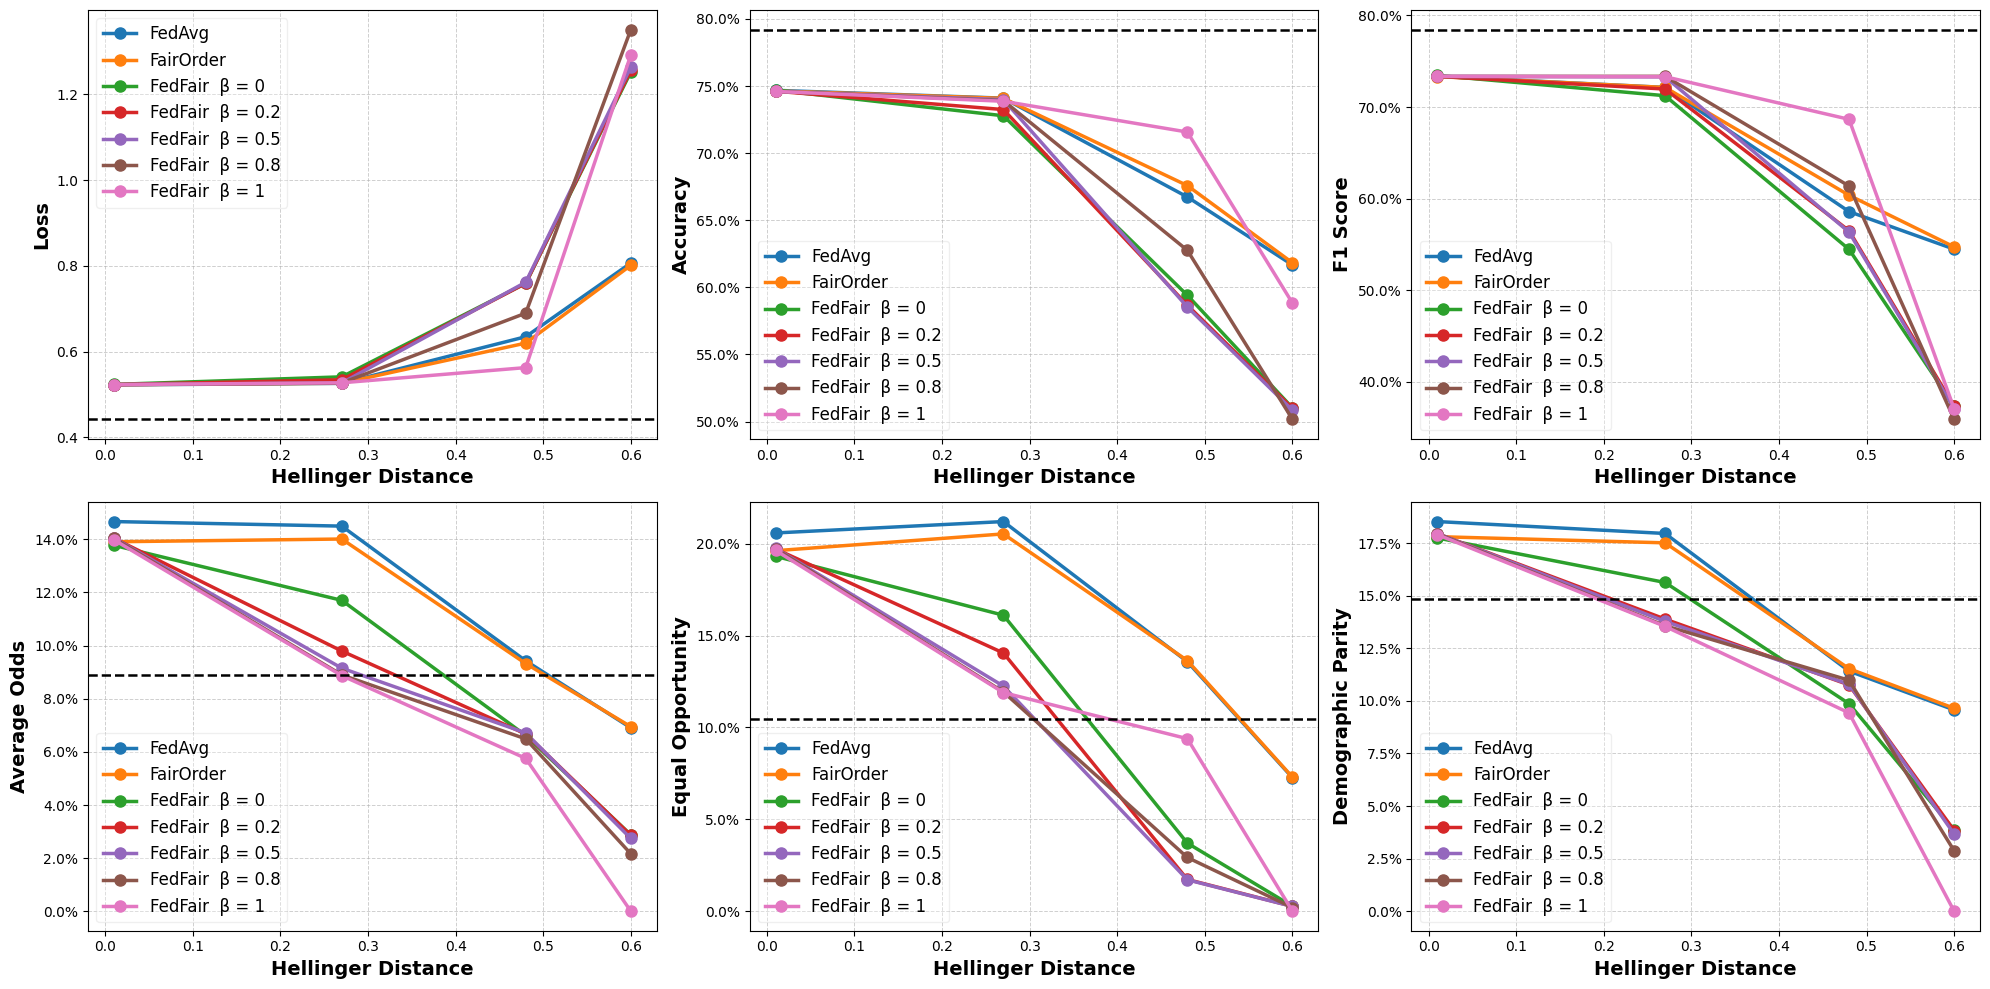

In [ ]:
y_limits = plot_non_iid_comp(alpha_dict, label_data, baseline_metrics)

### Protected attribute distribution skew

In [ ]:
args.partition = "attr"
alpha_dict =  {1000: 0.01, 3: 0.21, 1: 0.42, 0.25: 0.54}
alpha_values = alpha_dict.keys()

algorithm_ids = ["fedavg", "fairorder", "fedfair"]
beta_values = [0, 0.2, 0.5, 0.8, 1]

base_folders = []

for algorithm_id in algorithm_ids:
  if (algorithm_id == "fedfair"):
    for beta in beta_values:
      base_folder = f"models/{DATASET_ID}/federated/{algorithm_id}/{args.partition}_skew/K_100/beta_{beta}/"
      base_folders.append(base_folder)
  else:
    base_folder = f"models/{DATASET_ID}/federated/{algorithm_id}/{args.partition}_skew/K_100/"
    base_folders.append(base_folder)

In [ ]:
metrics_array = []
for base_folder in base_folders:
  mean_metrics = evaluate_runs(args, alpha_values, base_folder)
  metrics_array.append(mean_metrics)

In [ ]:
methods = ["FedAvg", "FairOrder", "FedFair  β = 0", "FedFair  β = 0.2", "FedFair  β = 0.5", "FedFair  β = 0.8", "FedFair  β = 1"]
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(7)]

attr_metrics_array = metrics_array
attr_data = (methods, colors, attr_metrics_array)

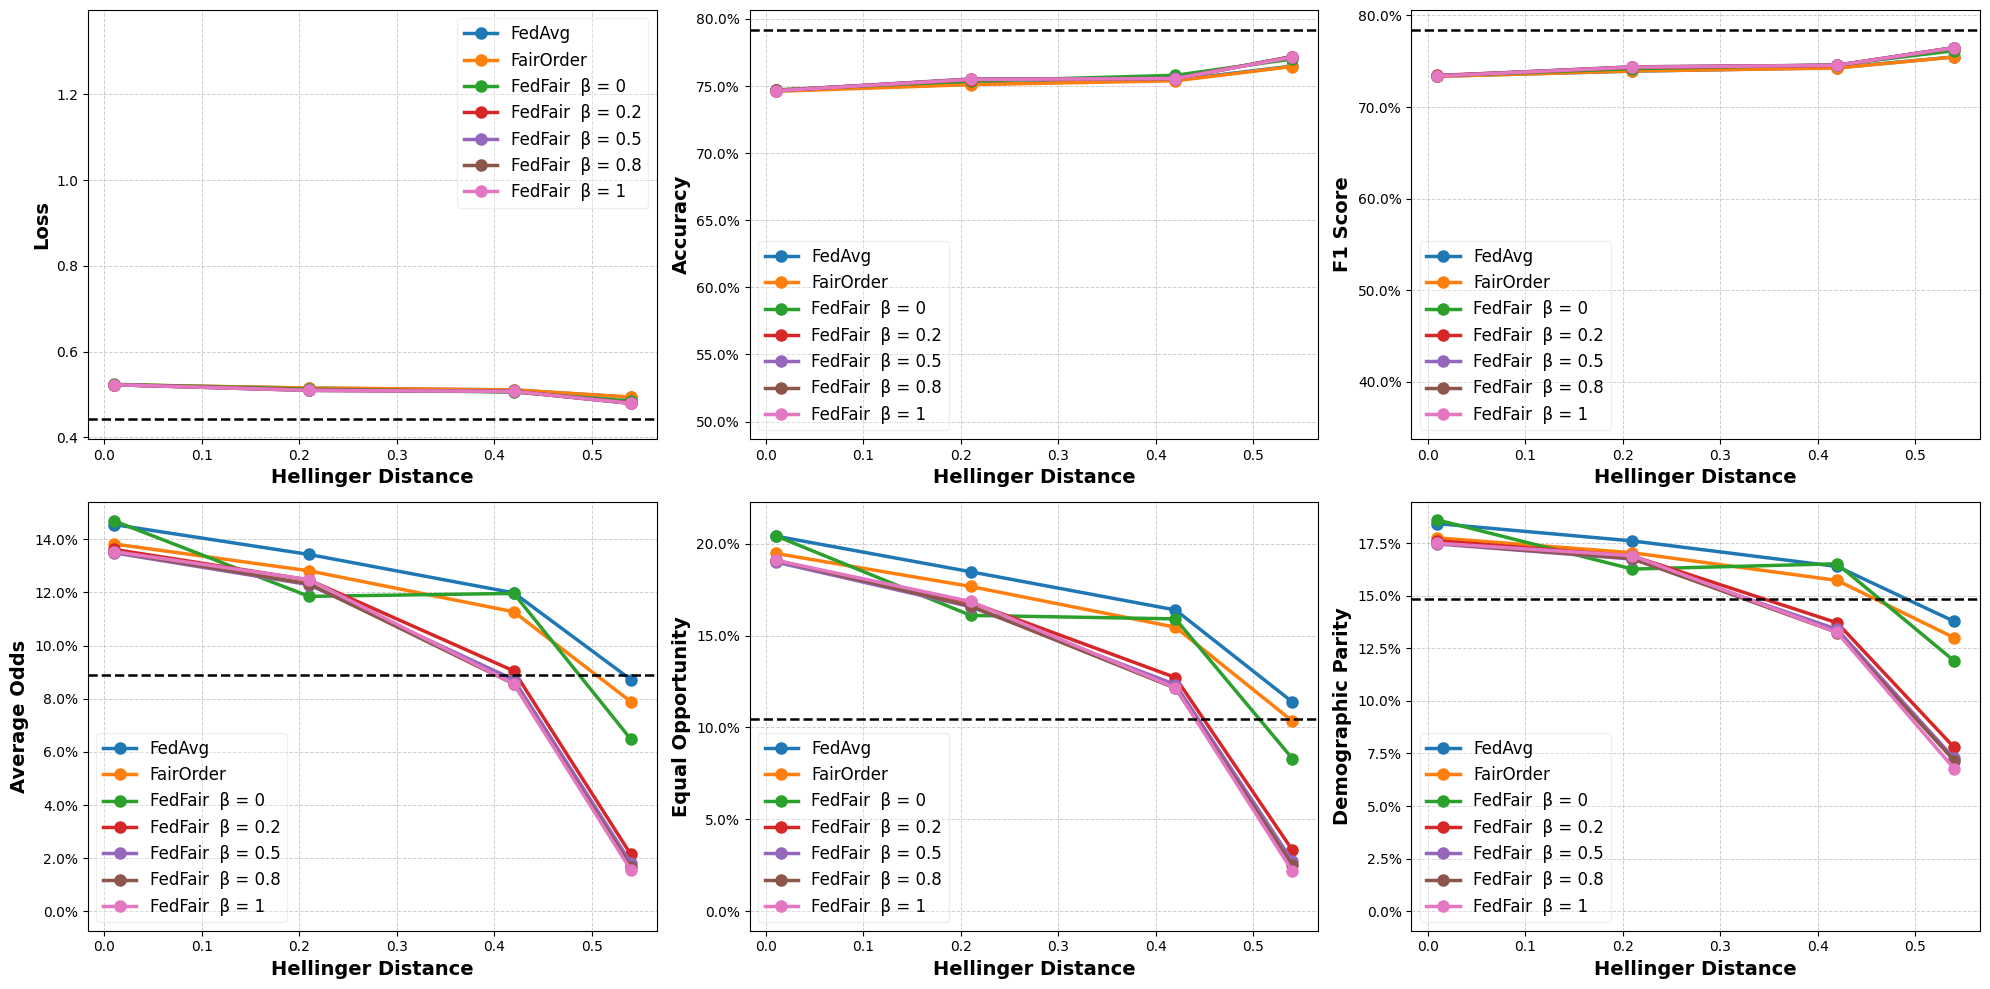

In [ ]:
_ = plot_non_iid_comp(alpha_dict, attr_data, baseline_metrics, y_limits)

## FedFair β factor analysis

In [ ]:
# Function to obtain the mean over multiple runs of each metric evaluated for a fixed alpha (HD) and different values of beta
def evaluate_runs_beta(alpha, save_folder, device, num_runs=5):

    beta_values = [0, 0.2, 0.5, 0.8, 1]
    metrics = { "loss": [], "acc": [], "f1": [], "ao": [], "eopp": [], "dp": [] }

    for beta in beta_values:

        beta_path = save_folder + f"beta_{beta}/alpha_{alpha}/"
        beta_metrics = { "loss": [], "acc": [], "f1": [], "ao": [], "eopp": [], "dp": [] }

        for run_idx in range(num_runs):
          save_path = beta_path + f"run_{run_idx}.pth"
          model = get_model(ckpt=save_path)

          results = evaluate(model, torch.nn.CrossEntropyLoss(), args.test_loader)

          for key, value in zip(beta_metrics.keys(), results):
            beta_metrics[key].append(value)

        for key in metrics:
            metrics[key].append(np.mean(beta_metrics[key]))

    return tuple(metrics[key] for key in metrics)

def extract_beta_data_runs(args, alpha_dict, alpha_values, skew, num_runs=5):

  labels = []
  metrics_array = []

  folder = f"models/{DATASET_ID}/federated/fedfair/{skew}_skew/K_100/"

  run_metrics = { "loss": [], "acc": [], "f1": [], "ao": [], "eopp": [], "dp": [] }

  for run_idx in range(num_runs):
    fedavg_iid_path = f"models/{DATASET_ID}/federated/fedavg/{skew}_skew/K_100/alpha_{alpha_values[0]}/run_{run_idx}.pth"
    fedavg_iid_model = get_model(ckpt=fedavg_iid_path)
    metrics = evaluate(fedavg_iid_model, torch.nn.CrossEntropyLoss(), args.test_loader)
    for key, value in zip(run_metrics.keys(), metrics):
      run_metrics[key].append(value)

  fedavg_metrics = []
  for key in run_metrics.keys():
    fedavg_metrics.append(np.mean(run_metrics[key]))

  for i, alpha in enumerate(alpha_values):
    if i == 0:
      labels.append("IID")
    else:
      labels.append(f"HD = {alpha_dict[alpha]} (α = {alpha})")
    metrics = evaluate_runs_beta(alpha, folder, device, num_runs)
    metrics_array.append(metrics)

  cmap = plt.get_cmap('tab10')
  colors = [cmap(i / len(metrics_array)) for i in range(1, len(metrics_array) + 1)]

  return labels, colors, metrics_array, fedavg_metrics

In [ ]:
# Function to plot the comparison of the relationship between beta and values
def plot_beta_comp(alpha_dict, data, y_limits=None):

  beta_values = [0, 0.2, 0.5, 0.8, 1]
  methods, colors, values, fedavg_metrics = data
  y_labels = ['Loss', 'Accuracy', 'F1 Score', 'Average Odds', 'Equal Opportunity', 'Demographic Parity']

  # Create subplots
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))

  # Record the range of y values for all plots
  out_limits = []

  # Iterate through subplots
  for idx, ax in enumerate(axs.flat):
    ax.set_xlabel("Beta", fontsize=14, fontweight='bold')
    ax.set_ylabel(y_labels[idx], fontsize=14, fontweight='bold')

    # Check if the current plot is for Loss, otherwise convert values to percentages
    if y_labels[idx] != 'Loss':
        # Convert both method values and baseline values to percentages
        current_values = [[val * 100 for val in value[idx]] for value in values]
        fedavg_value = fedavg_metrics[idx] * 100
        ax.yaxis.set_major_formatter(PercentFormatter())
    else:
        # Keep Loss as is (in decimals)
        current_values = [value[idx] for value in values]
        fedavg_value = fedavg_metrics[idx]

    # Plot each method's results with thicker lines and markers
    for i in range(len(values)):
        ax.plot(beta_values, current_values[i], label=methods[i], color=colors[i],
                linewidth=2.5, marker='o', markersize=8)

    # Add grid and legend
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)
    ax.legend(fontsize=12, loc='best', fancybox=True, framealpha=0.3)

    cmap = plt.get_cmap('tab10')
    fedavg_color = cmap(0)

    # Add baseline line with a dashed black line
    ax.axhline(y=fedavg_value, color=fedavg_color, linestyle='--', linewidth=1.8)

    # Add margin, then manually adjust limits
    ax.margins(y=0.3)
    y_lim = ax.get_ylim()
    ax.set_ylim(max(0, y_lim[0]), y_lim[1])

    # Set y axis range if set
    if y_limits is not None:
      ax.set_ylim(y_limits[idx])

    # Get the range of y values
    y_lim = ax.get_ylim()
    out_limits.append(y_lim)

  # Adjust layout and show the plot
  plt.tight_layout()
  plt.show()

  return out_limits

### Label distribution skew

In [ ]:
alpha_dict =  {1000: 0.01, 5: 0.27, 0.5: 0.48, 0.2: 0.6}
alpha_values = list(alpha_dict.keys())

label_data = extract_beta_data_runs(args, alpha_dict, alpha_values, "label")

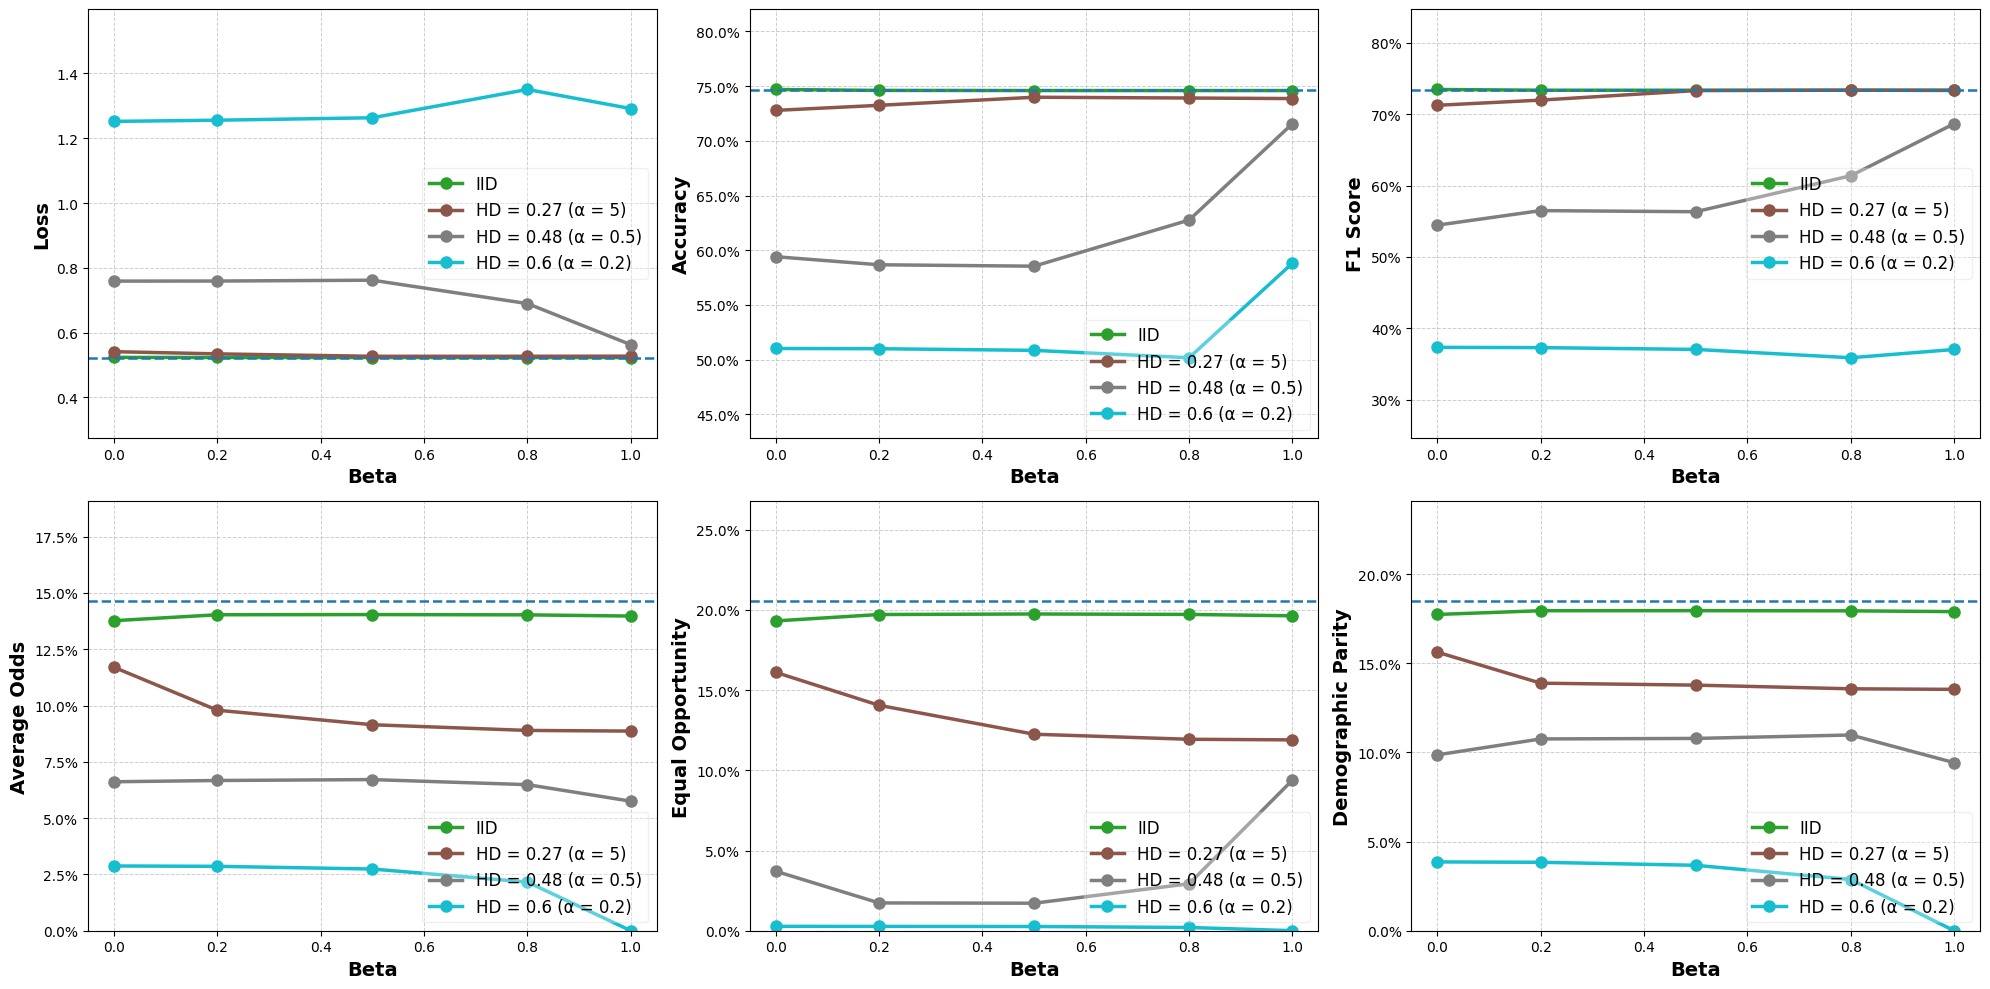

In [ ]:
y_limits = plot_beta_comp(alpha_dict, label_data)

### Protected attribure distribution skew

In [ ]:
alpha_dict =  {1000: 0.01, 3: 0.21, 1: 0.42, 0.25: 0.54}
alpha_values = list(alpha_dict.keys())

attr_data = extract_beta_data_runs(args, alpha_dict, alpha_values, "attr")

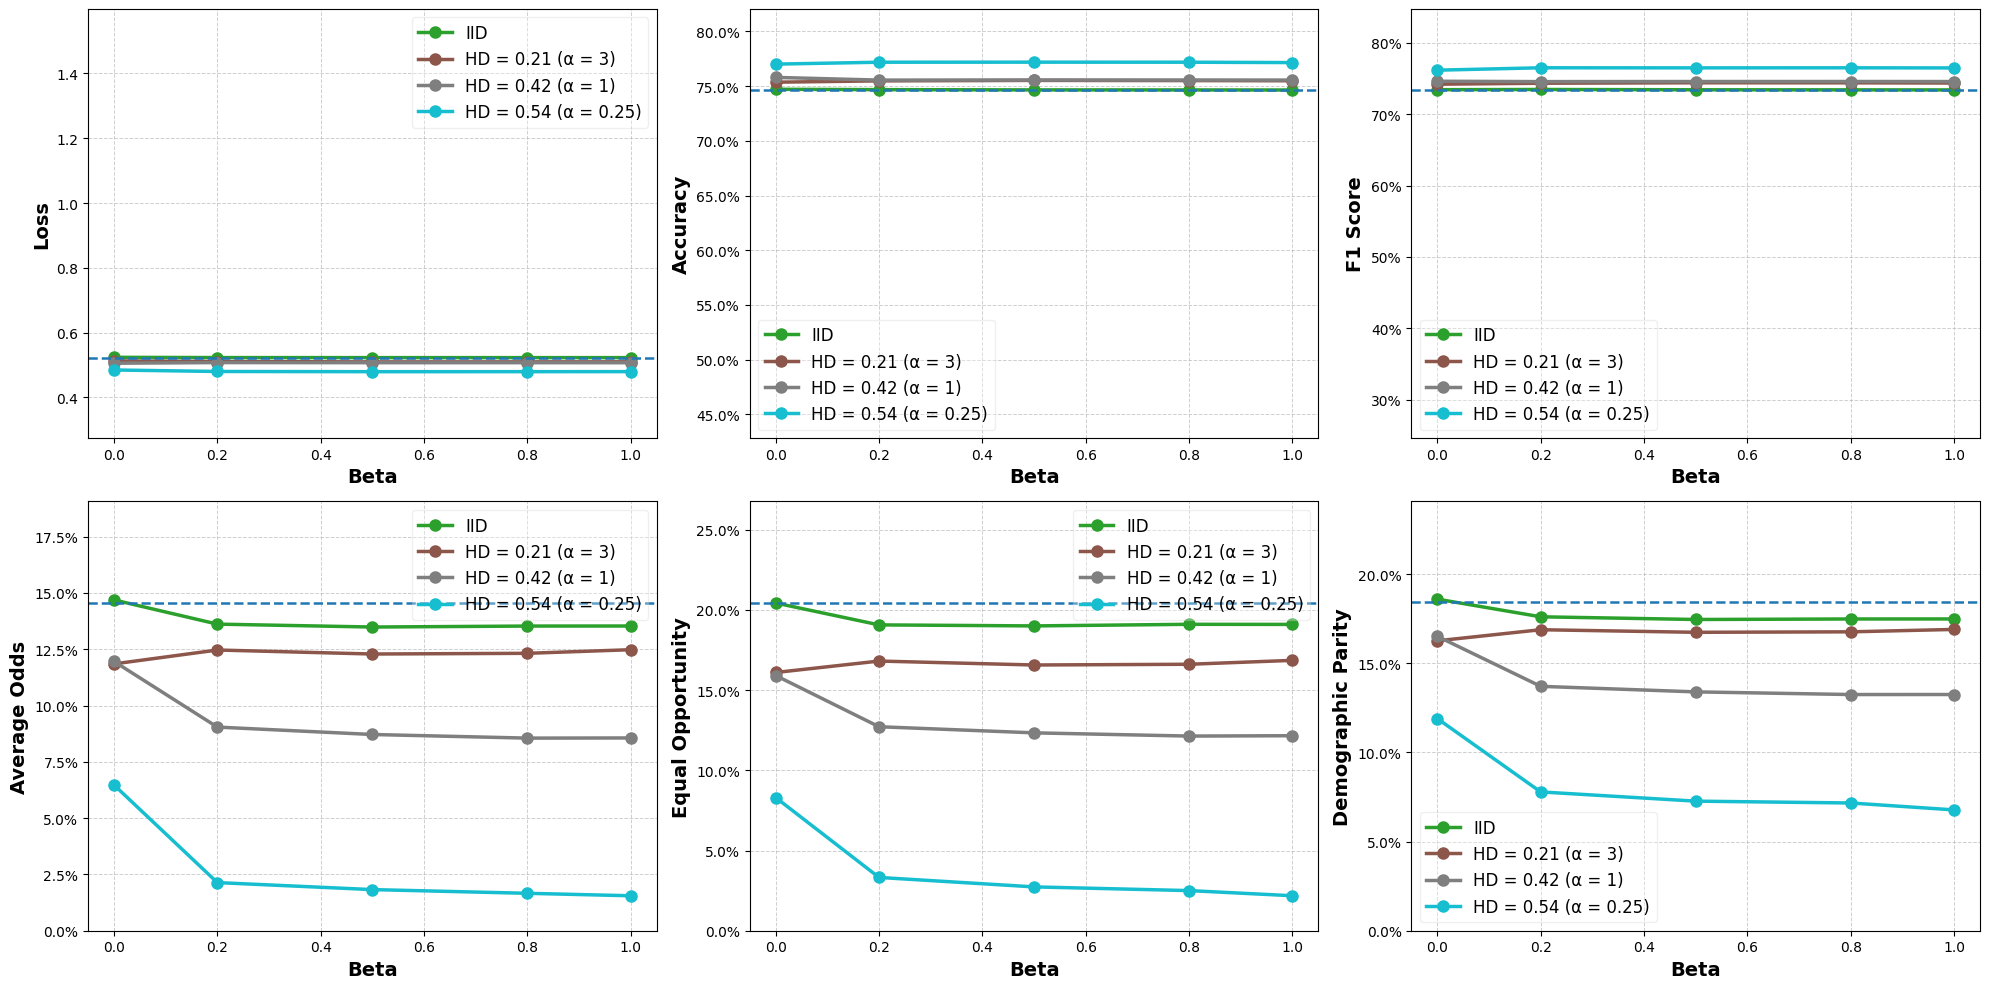

In [ ]:
_ = plot_beta_comp(alpha_dict, attr_data, y_limits)